In [6]:
from pyspark import SparkConf, SparkContext
from pyspark.ml.feature import HashingTF,IDF,Tokenizer
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.session import SparkSession
import pandas as pd
import jieba
import os

res_location = '/mnt/hgfs/share_file/result/'
os.chdir(res_location)

conf = SparkConf().setMaster('spark://master:7077').setAppName('data_analysis_1')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/spark/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/hadoop/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]


2022-01-17 15:03:39 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [247]:
introduction_total = sc.textFile("hdfs://master:9000/user/zyq/jiayuan_female_intro.csv").union(
                     sc.textFile("hdfs://master:9000/user/zyq/jiayuan_male_intro.csv")).union(
                     sc.textFile("hdfs://master:9000/user/zyq/jiayuan_intro.csv")).union(
                     sc.textFile("hdfs://master:9000/user/zyq/zhenai_intro.csv")).distinct().filter(lambda x: len(x) > 0).cache()

In [276]:
introduction_female = sc.textFile("hdfs://master:9000/user/zyq/jiayuan_female_intro.csv").distinct().filter(lambda x: len(x) > 0).cache()
introduction_male = sc.textFile("hdfs://master:9000/user/zyq/jiayuan_male_intro.csv").distinct().filter(lambda x: len(x) > 0).cache()

In [275]:
stop_words = sc.textFile("hdfs://master:9000/user/zyq/stopwords.txt").union(sc.parallelize(['']))
stop_words_set = set(stop_words.collect())

## 分词后进行词频统计

In [271]:
words = introduction_total.map(lambda w: '/'.join(jieba.cut(w))).flatMap(lambda line: line.split('/'))

In [272]:
filter_words = words.subtract(stop_words)

In [273]:
word_counts= filter_words.map(lambda x: (x, 1)).reduceByKey(lambda a,b: a + b).sortBy(lambda x: [-x[1], x[0]])

In [ ]:
words_female = introduction_female.map(lambda w: '/'.join(jieba.cut(w))).flatMap(lambda line: line.split('/'))
filter_words_female = words_female.subtract(stop_words)
word_counts_female= filter_words_female.map(lambda x: (x, 1)).reduceByKey(lambda a,b: a + b).sortBy(lambda x: [-x[1], x[0]])
word_counts_female.filter(lambda x: x[1] > 10).collect()

In [ ]:
words_male = introduction_male.map(lambda w: '/'.join(jieba.cut(w))).flatMap(lambda line: line.split('/'))
filter_words_male = words_male.subtract(stop_words)
word_counts_male= filter_words_male.map(lambda x: (x, 1)).reduceByKey(lambda a,b: a + b).sortBy(lambda x: [-x[1], x[0]])
word_counts_male.filter(lambda x: x[1] > 10).collect()

In [ ]:
word_counts.filter(lambda x: x[1] > 10).collect()

In [287]:
# 存储结果
word_frequency = pd.DataFrame(word_counts.filter(lambda x: x[1] > 10).collect(), columns=['word', 'counts'])
word_frequency.to_csv('word_frequency_total.csv', index=False)


[Stage 9970:================>                                       (2 + 2) / 7]


## 频繁模式挖掘

In [155]:
intro_words = introduction.map(lambda w: '/'.join(jieba.cut(w))).map(lambda line: line.split('/')).filter(lambda x: len(x) >  0)
def stop_words_filter(words):
    return list(set(words) - stop_words_set)

In [ ]:
intro_wordsdsds.take(3)

In [156]:
df = spark.createDataFrame(intro_words.map(stop_words_filter).map(lambda x: (len(x), x)).collect(), ['len', 'sentence'])

In [159]:
df.printSchema()

root
 |-- len: long (nullable = true)
 |-- sentence: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [164]:
fpGrowth = FPGrowth(itemsCol="sentence", minSupport=0.005, minConfidence=0.001)
model = fpGrowth.fit(df)


model.freqItemsets.show()

2022-01-12 15:03:35 WARN  FPGrowth:66 - Input data is not cached.
2022-01-12 15:03:35 WARN  TaskSetManager:66 - Stage 151 contains a task of very large size (4211 KB). The maximum recommended task size is 100 KB.


2022-01-12 15:03:38 WARN  TaskSetManager:66 - Stage 152 contains a task of very large size (4211 KB). The maximum recommended task size is 100 KB.


2022-01-12 15:03:40 WARN  TaskSetManager:66 - Stage 154 contains a task of very large size (4211 KB). The maximum recommended task size is 100 KB.


[Stage 155:>                                                        (0 + 1) / 1]

+------------+----+
|       items|freq|
+------------+----+
|        [过好]| 287|
|        [我要]| 280|
|        [介绍]| 284|
|         [现]| 291|
|        [负责]| 354|
|        [只能]| 283|
|        [风趣]| 296|
|      [兴趣爱好]| 279|
|        [做人]| 322|
|      [大大咧咧]| 308|
|       [事业心]| 287|
|         [谱]| 289|
|         [钱]| 347|
|         [手]| 339|
|      [与子偕老]| 329|
|[与子偕老, 执子之手]| 310|
|        [关系]| 292|
|        [寻觅]| 343|
|       [找对象]| 304|
|        [分享]| 277|
+------------+----+
only showing top 20 rows



In [169]:
model.associationRules.show()

+----------+----------+-------------------+
|antecedent|consequent|         confidence|
+----------+----------+-------------------+
|      [勿扰]|       [请]|0.13549682167949148|
|      [勿扰]|      [性格]|   0.09401137504182|
|      [勿扰]|      [生活]|0.13315490130478422|
|      [勿扰]|      [工作]| 0.1415189026430244|
|      [勿扰]|      [善良]|0.12947474071595852|
|      [勿扰]|     [另一半]|0.09836065573770492|
|      [勿扰]|      [真心]| 0.1291401806624289|
|      [勿扰]|      [喜欢]| 0.1796587487453998|
|      [勿扰]|      [真诚]|0.15356306457009034|
|      [勿扰]|       [爱]| 0.1050518568082971|
|      [勿扰]|      [余生]|0.12278353964536634|
|      [勿扰]|      [希望]|0.29876212780194045|
|      [勿扰]|      [结婚]|0.12244897959183673|
|      [勿扰]|      [离异]|0.11809969889595183|
|      [勿扰]|      [非诚]| 0.5935095349615256|
|  [成熟, 稳重]|      [喜欢]|0.35160905840286055|
|  [成熟, 稳重]|      [希望]|0.45530393325387364|
|  [善良, 生活]|      [喜欢]|0.40899122807017546|
|  [善良, 生活]|      [希望]| 0.4517543859649123|
|      [贤惠]|      [温柔]| 0.528756

In [167]:
pandas_df = model.freqItemsets.toPandas()

In [172]:
model.associationRules.toPandas().to_csv('/mnt/hgfs/share_file/test2.csv', index=False)

### 聚类

In [125]:
import matplotlib.pyplot as plt
%matplotlib notebook
data = spark.read.csv("hdfs://master:9000/user/zyq/criterias_test.csv",  header=True, inferSchema=True) # 类型推断

In [126]:
data.show()

+------------+-----------+---------------+--------------+-------------------+------------------+
|age_flooring|age_ceiling|height_flooring|height_ceiling|criterias_education|criterias_marriage|
+------------+-----------+---------------+--------------+-------------------+------------------+
|          41|         49|            170|           178|                  5|                 2|
|          27|         39|            170|           190|                  1|                 1|
|          33|         41|            168|           183|                  1|                 1|
|          38|         45|            165|           181|                  2|                 1|
|          24|         30|            172|           185|                  3|                 4|
|          37|         44|            160|           178|                  2|                 1|
|          32|         45|            130|           260|                  1|                 1|
|          45|         52|    

In [128]:
data.printSchema()

root
 |-- age_flooring: integer (nullable = true)
 |-- age_ceiling: integer (nullable = true)
 |-- height_flooring: integer (nullable = true)
 |-- height_ceiling: integer (nullable = true)
 |-- criterias_education: integer (nullable = true)
 |-- criterias_marriage: integer (nullable = true)



In [129]:
from pyspark.ml.feature import VectorAssembler
assemble = VectorAssembler(inputCols=data.columns, outputCol='features')
assembled_data = assemble.transform(data)

In [130]:
assembled_data.show(2)

+------------+-----------+---------------+--------------+-------------------+------------------+--------------------+
|age_flooring|age_ceiling|height_flooring|height_ceiling|criterias_education|criterias_marriage|            features|
+------------+-----------+---------------+--------------+-------------------+------------------+--------------------+
|          41|         49|            170|           178|                  5|                 2|[41.0,49.0,170.0,...|
|          27|         39|            170|           190|                  1|                 1|[27.0,39.0,170.0,...|
+------------+-----------+---------------+--------------+-------------------+------------------+--------------------+
only showing top 2 rows



#### 标准化

In [131]:
from pyspark.ml.feature import StandardScaler

scale = StandardScaler(inputCol='features',outputCol='standardized')

data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)

In [150]:
data_process = data_scale_output.select('standardized')

#### 根据Silhouette Coefficient轮廓系数选取k值

In [181]:
from pyspark.ml.clustering import KMeans,KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized')


for i in range(2, 100):
    kmeansmodel = KMeans().setK(i).setFeaturesCol('standardized').setPredictionCol('prediction').fit(data_process)
    predictions = kmeansmodel.transform(data_process)
    silhouette = evaluator.evaluate(predictions)
    res.append((i, str(silhouette)))
    
res.sort(key=lambda x: x[1],reverse=True)
res

#### 聚类k选取20

<IPython.core.display.Javascript object>


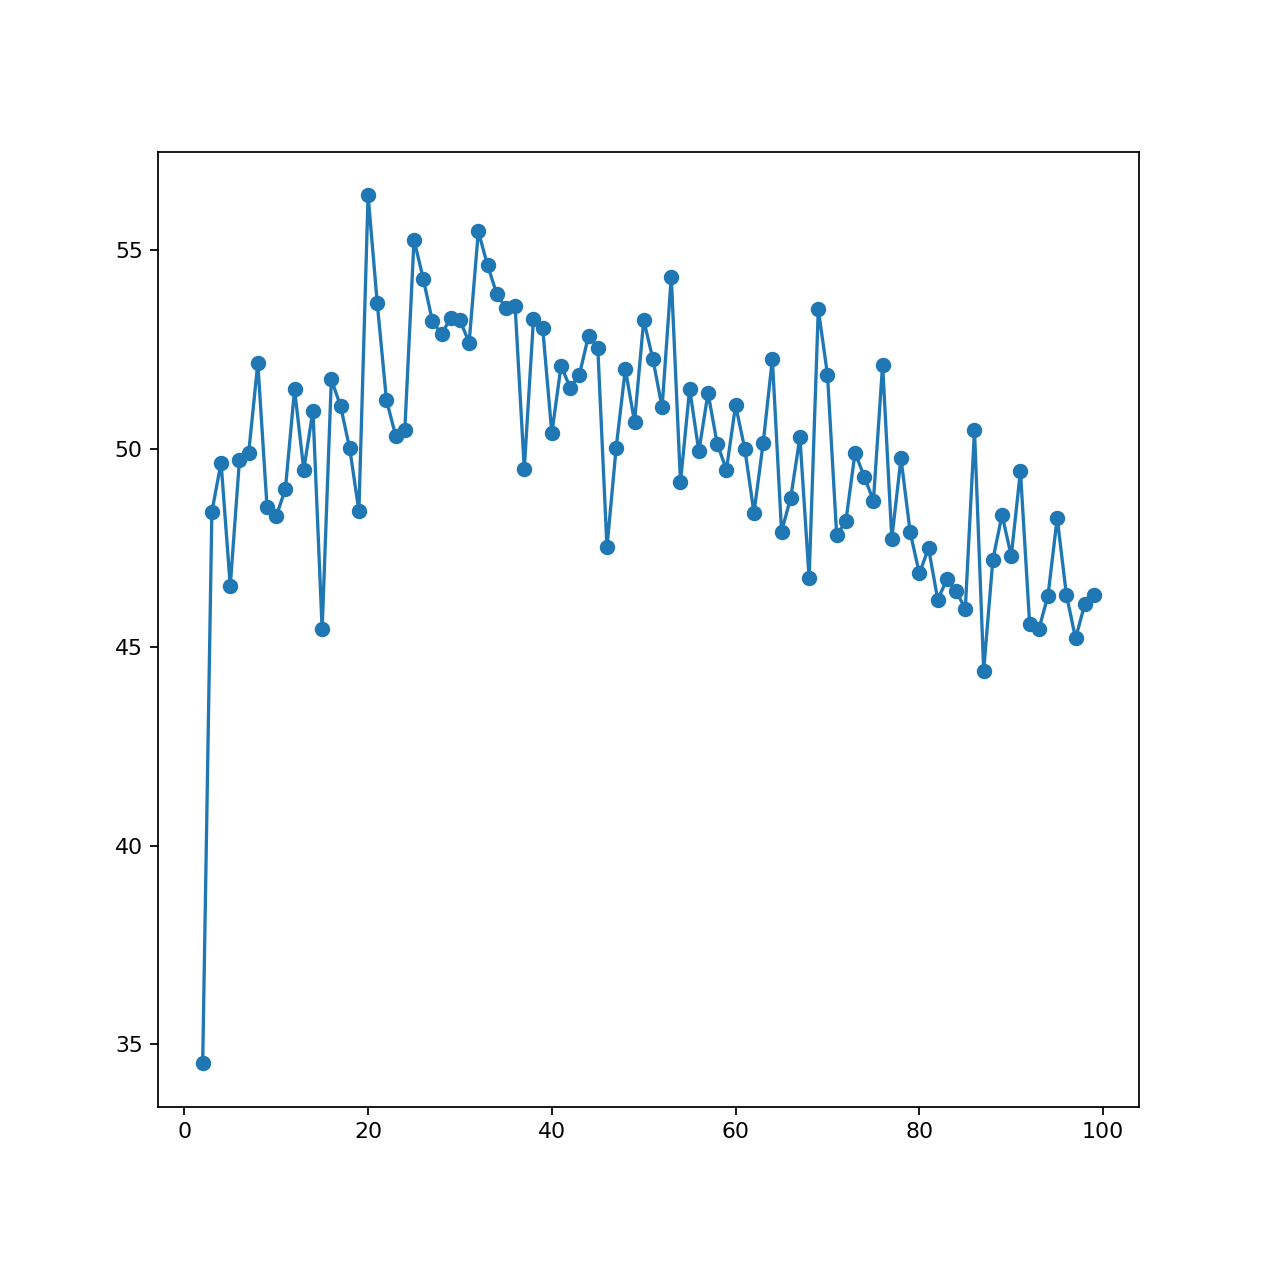

In [198]:
tmp = [float(item[1])*100 for item in sorted(res)]
plt.figure(figsize=(8.0, 8.0))
plt.plot(range(2,100), tmp, 'o-')

In [204]:
kmeansmodel = KMeans().setK(20).setFeaturesCol('standardized').setPredictionCol('prediction').fit(data_process)

In [238]:
columns = data.columns
columns.append('prediction')

In [243]:
results = kmeansmodel.transform(data_scale_output).select(columns)

In [244]:
results.toPandas().to_csv('/mnt/hgfs/share_file/cluster.csv', index=False)